# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Rubric points
#### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

You're reading it!



### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the file `src/camera_calibrator.py` and invoked in the following cells below:

* `CameraCalibrator.fit` is responsible for searching the corners on a chessboard matrix. I prepare ***object points*** which are the 3D coordinated of the chessboard corners and with `cv2.findChessboardCorners` I find ***image points*** which are the 2D representation in the image plane. I use them to find the camera matrix and distortion coefficients using `cv2.calibrateCamera`

* `CameraCalibrator.transform` takes those variables and with `cv2.undistort()` it applies distortion correction. You can see the sample output below

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

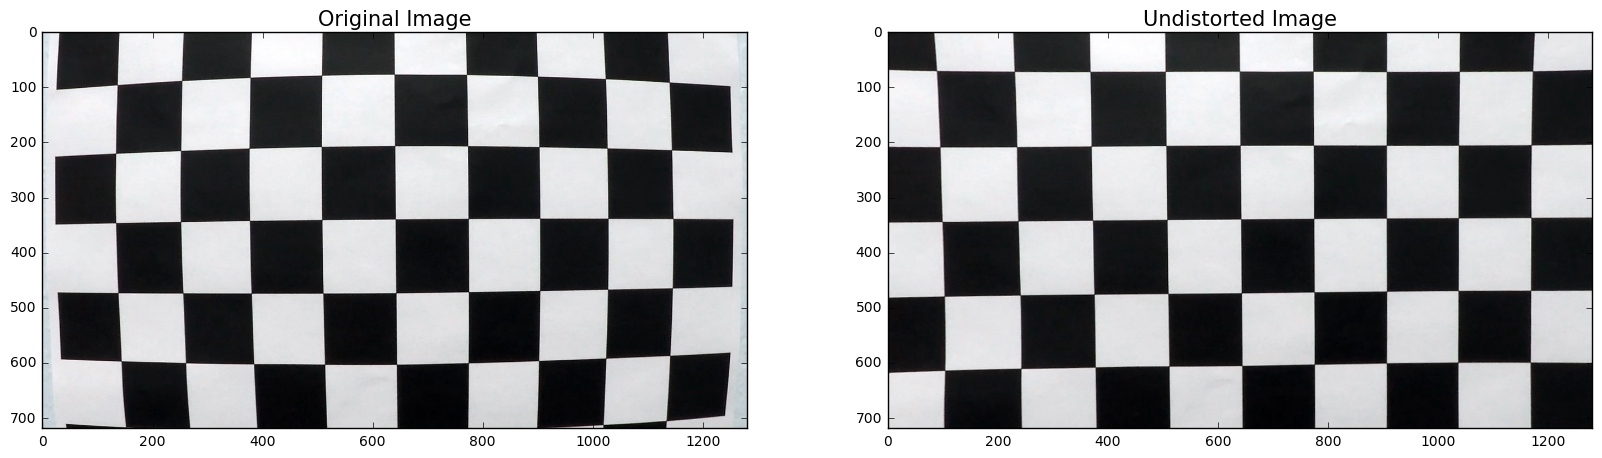

In [2]:
calibration_images_paths = glob.glob('camera_cal/calibration*.jpg')
img_1 = cv2.imread(calibration_images_paths[0])

from src.camera_calibrator import CameraCalibrator
calibrator = CameraCalibrator(9, 6)
calibrator.fit(calibration_images_paths)
calibrator.transform(img_1, True);

### Pipeline (single images)    
#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one: 

In [3]:
# Make a list of test images
test_images_paths = glob.glob('test_images/*.jpg')
test_images = [mpimg.imread(img) for img in test_images_paths]
undistorted_test_images = [calibrator.transform(img) for img in test_images]

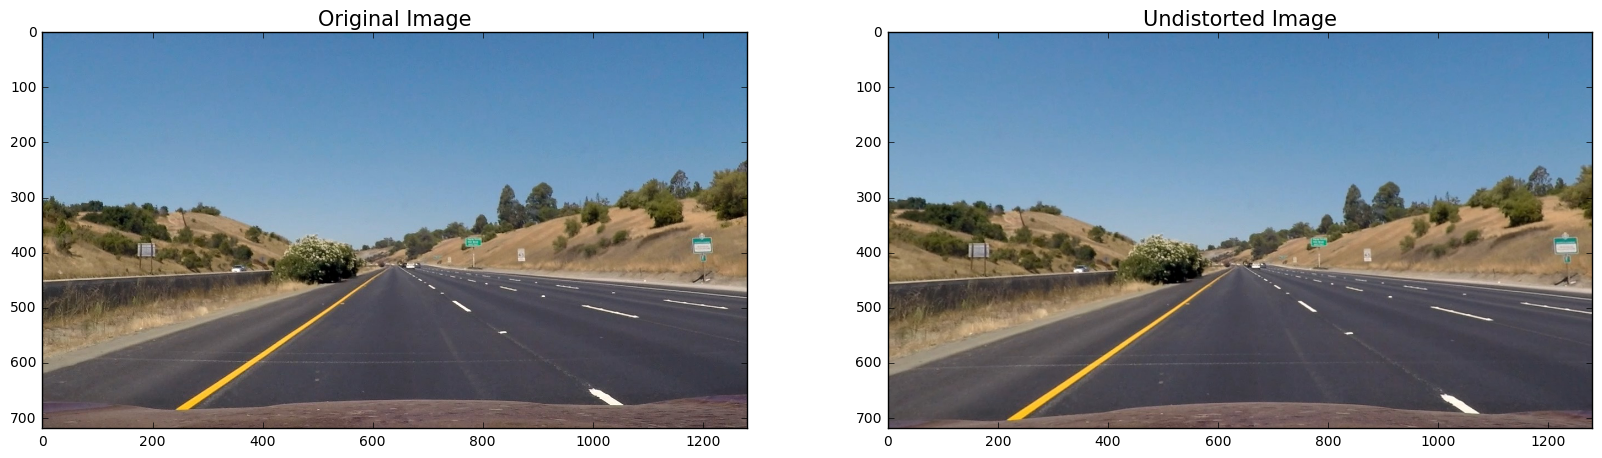

In [4]:
calibrator.transform(test_images[0], True);

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

` ImageThresholder` class from `src/image_thresholder.py` class is responsible for creation of the thresholded images.

I used a combination of HLS color (using Hue and Saturation) and Sobel X gradient thresholds to generate a binary image Here's an example of my output for this step:

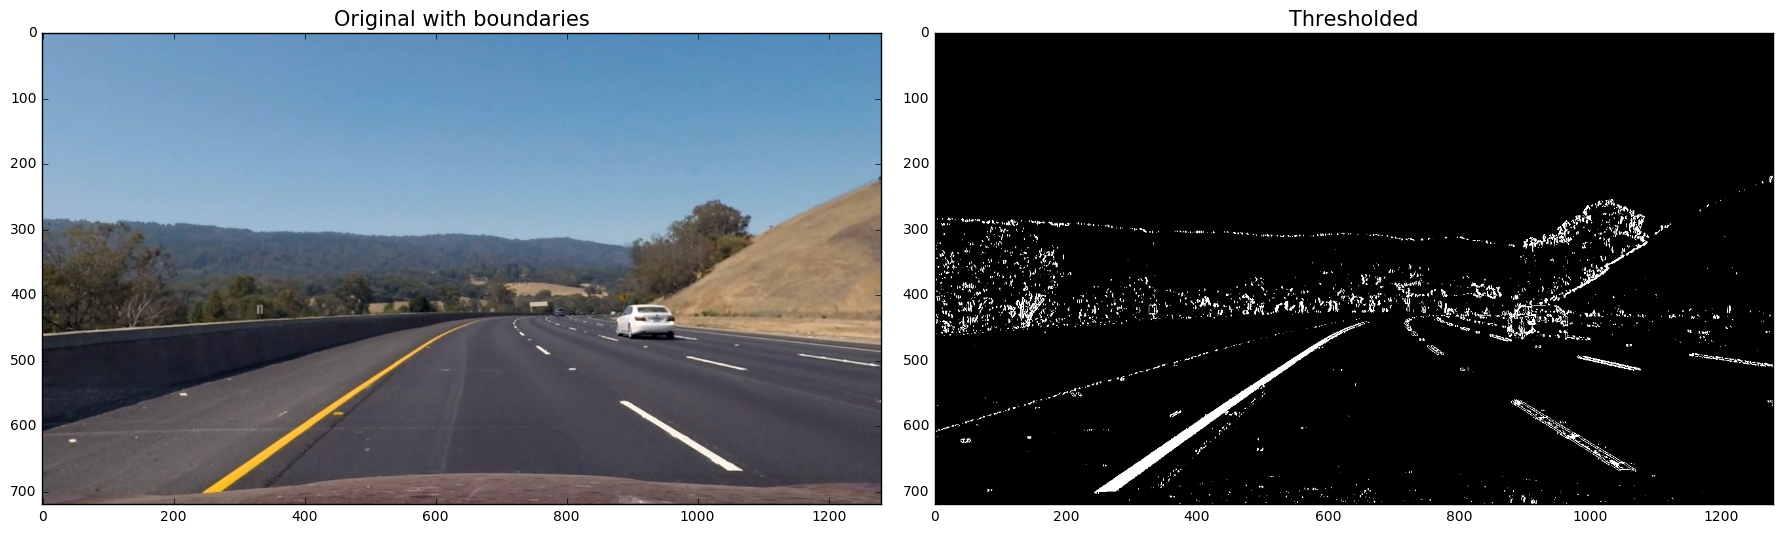

In [5]:
from src.image_thresholder import ImageThresholder
img0 = np.copy(undistorted_test_images[4])
img_thresholded = ImageThresholder.threshold(img0)[1]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(img0)
ax1.set_title('Original with boundaries', fontsize=15)
ax2.imshow(img_thresholded, cmap="gray")
ax2.set_title('Thresholded', fontsize=15)

***3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.***

`PerspectiveTransformer` class from `src/perspective_transformer.py` class is responsible for the warping of the images.

* `PerspectiveTransformer.computePerspectiveTransform` is responsible for finding the transformation matrix M and the inverse transformation matrix Minv. I find 4 preselected source points (defined as a constant `WARP_SRC_POINTS`) and compute the transformation for destintation points using `cv2.getPerspectiveTransform`

* `PerspectiveTransformer.warp` is responsible for the actual warping given matrix M for a given image. It uses `cv2.warpPerspective`

* Additionally I crop the warped image with `PerspectiveTransformer.crop` to focus on the "interesting" part of the road from the point of view of this exercise.

See below output for example of warped image.

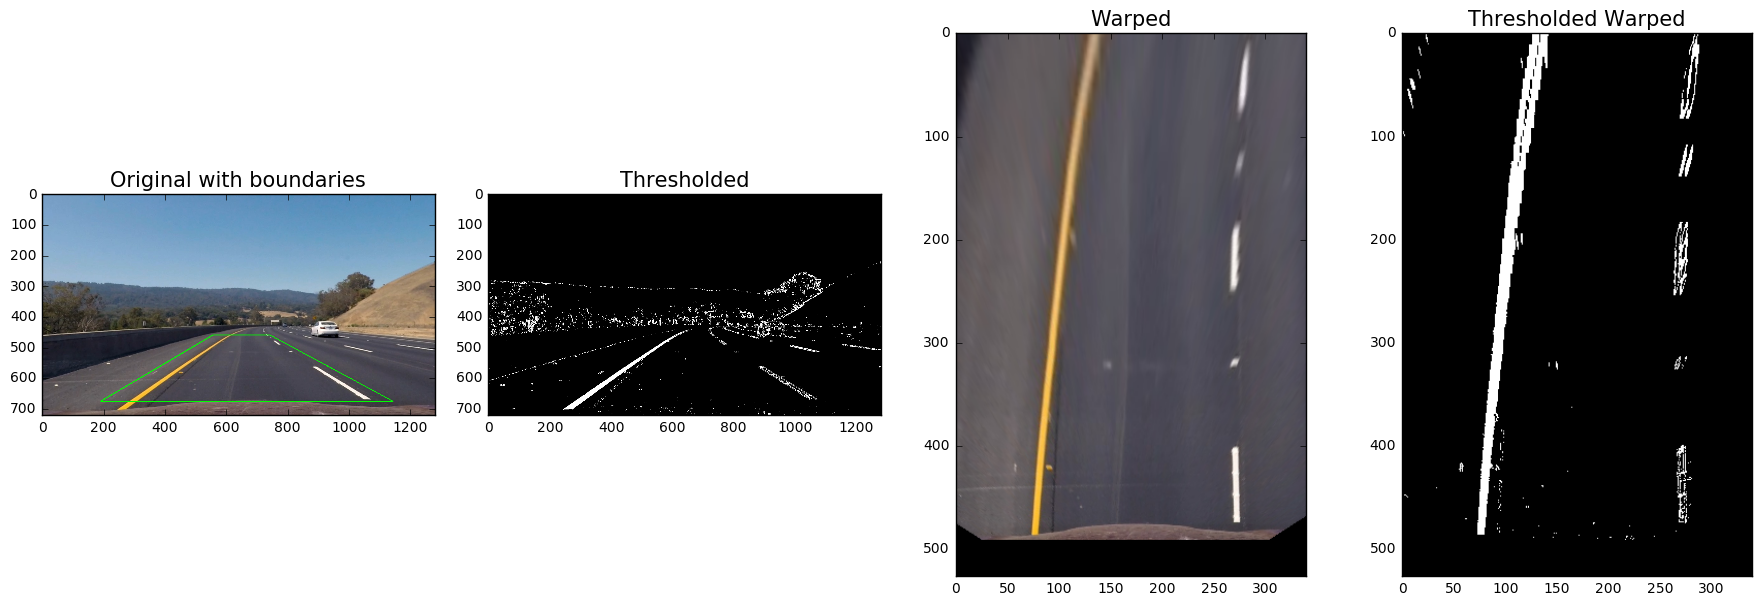

In [6]:
from src.image_thresholder import ImageThresholder
from src.perspective_transformer import WARP_SRC_POINTS, PerspectiveTransformer

img0 = np.copy(undistorted_test_images[4])

polypoints = WARP_SRC_POINTS[[1, 0, 2, 3]]
polyimg = np.copy(img0)
cv2.polylines(polyimg, [polypoints], 1, (0,255,0), 2)

perspective_transformer = PerspectiveTransformer()
perspective_transformer.computePerspectiveTransform(img0)

img_thresholded = ImageThresholder.threshold(img0)[1]
cropped_warped_img = perspective_transformer.warp_and_crop(img0)
cropped_warped_thresholded = perspective_transformer.warp_and_crop(img_thresholded)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6))
f.tight_layout()
ax1.imshow(polyimg)
ax1.set_title('Original with boundaries', fontsize=15)
ax2.imshow(img_thresholded, cmap="gray")
ax2.set_title('Thresholded', fontsize=15)
ax3.imshow(cropped_warped_img)
ax3.set_title('Warped', fontsize=15)
ax4.imshow(cropped_warped_thresholded, cmap="gray")
ax4.set_title('Thresholded Warped', fontsize=15)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

All of the logic for this step is contained in a `LineDetector` class from `src/line_detector.py`. It contains two members of class `Line` for right and left line.

* `LineDetector.detect` contains separate logic whether we are starting from scratch (i.e. either left or right line has `self.detected = False`. This can happen if it's the first image we're processing or if the difference between current fit and previous fit is too large.

* `LineDetector.detect_first` computes a histogram in the lower part of the image to find peaks of pixels. It then goes iteratively up to find appropriate pixels responsible for lane lines. Once we have iterated over the image we compute a polynomial fit using `np.polyfit` for each line

* `LineDetector.detect_next` uses the coefficients from previous averaged fits to extract pixels and update the fit

* `LineDetector.update_lines` appends and averages fits as we process more images to provide smoother calculations

Sample output from the class below:

/Users/mzielinski/code/sdcn/CarND-Advanced-Lane-Lines/src/line_detector.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(img[img.shape[0] / 2:, :], axis=0)


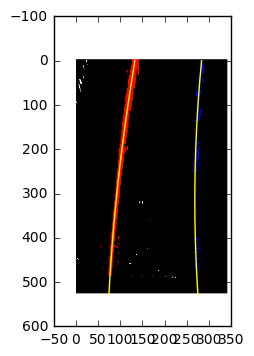

In [7]:
from src.line_detector import LineDetector
line_detector = LineDetector()
line_detector.detect_first(cropped_warped_thresholded)
line_detector.detect_next(cropped_warped_thresholded, True)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

`LineDetector.calculate_radius` takes the calculations from individual lines and averages them.
`Line.calculate_radius` uses fitted averaged fitted pixels and converts them to the "real-world" scale.

Example output for the fitted class:

In [8]:
line_detector.calculate_radius()

1282.6378556883865

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

This is done in the `ImageAnnotator` class from `src/image_annotator.py`. I have custom annotation methods for:
* radius plotting
* distance calculation and plotting
* unwarping the discovered lanes and lane lines

Output can be seen below:

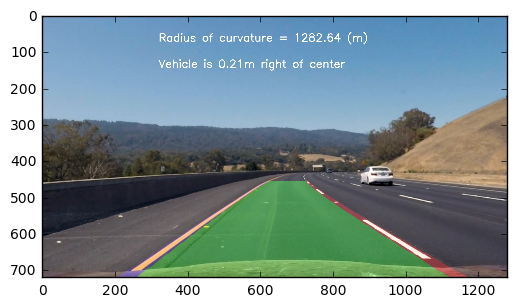

In [9]:
from src.image_annotator import ImageAnnotator
annotator = ImageAnnotator(perspective_transformer, line_detector)
annotated = annotator.annotate(img0)
plt.imshow(annotated)

### Pipeline (video)

#### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Results are under output_images/annotated_video.mp4

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

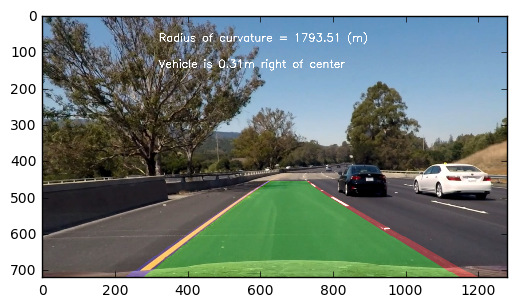

In [11]:
line_detector = LineDetector(30, 0.2)

def process_image(img):
    perspective_transformer = PerspectiveTransformer()
    perspective_transformer.computePerspectiveTransform(img)

    img_thresholded = ImageThresholder.threshold(img)[1]
    cropped_warped_thresholded = perspective_transformer.warp_and_crop(img_thresholded)

    line_detector.detect(cropped_warped_thresholded)

    annotator = ImageAnnotator(perspective_transformer, line_detector)
    annotated = annotator.annotate(img)
    
    return annotated

img_test = np.copy(undistorted_test_images[7])
plt.imshow(process_image(img_test))

In [16]:
annotated_output = 'output_images/annotated_project_video_with_lines.mp4'
clip1 = VideoFileClip("annotated_project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video output_images/annotated_project_video_with_lines.mp4
[MoviePy] Writing video output_images/annotated_project_video_with_lines.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  8.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_project_video_with_lines.mp4 

CPU times: user 4min 2s, sys: 39.5 s, total: 4min 42s
Wall time: 2min 55s


In [15]:
annotated_output = 'output_images/annotated_test_video_with_lines.mp4'
clip1 = VideoFileClip("annotated_test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video output_images/annotated_test_video_with_lines.mp4
[MoviePy] Writing video output_images/annotated_test_video_with_lines.mp4


 97%|█████████▋| 38/39 [00:05<00:00,  6.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_test_video_with_lines.mp4 

CPU times: user 7.45 s, sys: 1.24 s, total: 8.7 s
Wall time: 7.15 s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The most ad hoc step taken was the binary thresholding. Although it works for a set of test images a more automated approach should perhaps be considered, e.g. a ML/optimization setting where we learn optimal thresholds based on ground truth.

Further improving the pipeline can be made easier by creating a small subclip where the pipeline has difficulties as processing that would be much faster. For instance, to extract a 3 second video from 41 to 43 you can use:

`subclip = VideoFileClip("project_video.mp4").subclip(41, 43)`

The subclip of the affected areas can be used to evaluate each step of the pipeline to find out where it might be failing (thresholding, warping, lane fitting etc).

Another idea would be implementing a side-by-side visualization of each step of the pipeline such as this so you can visualize for each mistake of the pipeline which step is the root cause. This can be achieved by concatenating the image arrays horizontally and vertically using numpy.hstack and numpy.vstack.